# 1. Проверка ресурсов

In [ ]:
!nvidia-smi

Mon May 12 15:25:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   51C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Установка зависимостей


In [ ]:
!pip install -q ultralytics roboflow

In [ ]:
# Для загрузки данных
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

# 3. Загрузка данных

In [ ]:
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(13)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
HOME = os.getcwd()
# Расположим обучающие данные в папку datasets
!mkdir {HOME}/datasets
%cd {HOME}/datasets

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets


## 3.1 Замена абсолютного пути на относительный
YOLO требует, чтобы пути к изображениям были относительными

In [ ]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

In [ ]:
%cd {HOME}

/content


# 4. Обучение модели

### Запустим обучение модели YOLOv8 со следующими параметрами:

```python
!yolo task=detect \                     # Ставлю задачу: обнаружение объектов (есть ещё segment, classify и другие)
      mode=train \                      # Режим: обучение модели (альтернативы: predict, val, export)
      model=yolov8x.pt \                # Базовая предобученная модель YOLOv8x (самая точная и тяжёлая)
      data={dataset.location}/data.yaml \  # Путь к конфигурации датасета: train/val директории и список классов
      batch=6 \                         # Размер батча — сколько изображений обрабатывается за один шаг
      epochs=50 \                       # Количество эпох (полных проходов по всему датасету)
      imgsz=1280 \                      # Размер входного изображения (1280x1280 пикселей)
      plots=True                        # Включает автосоздание графиков метрик обучения


In [ ]:
!yolo task=detect \
      mode=train \
      model=yolov8x.pt \
      data="{dataset.location}/data.yaml" \
      batch=6 \
      epochs=50 \
      imgsz=1280 \
      plots=True

100% 131M/131M [00:00<00:00, 420MB/s]
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/football-players-detection-10/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr

# 5. Результаты обучения

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml			 R_curve.png	      train_batch2.jpg
confusion_matrix_normalized.png  results.csv	      val_batch0_labels.jpg
confusion_matrix.png		 results.png	      val_batch0_pred.jpg
F1_curve.png			 train_batch0.jpg     val_batch1_labels.jpg
labels_correlogram.jpg		 train_batch1680.jpg  val_batch1_pred.jpg
labels.jpg			 train_batch1681.jpg  val_batch2_labels.jpg
P_curve.png			 train_batch1682.jpg  val_batch2_pred.jpg
PR_curve.png			 train_batch1.jpg     weights


## 5.1 Проверим матрицу ошибок.

/content


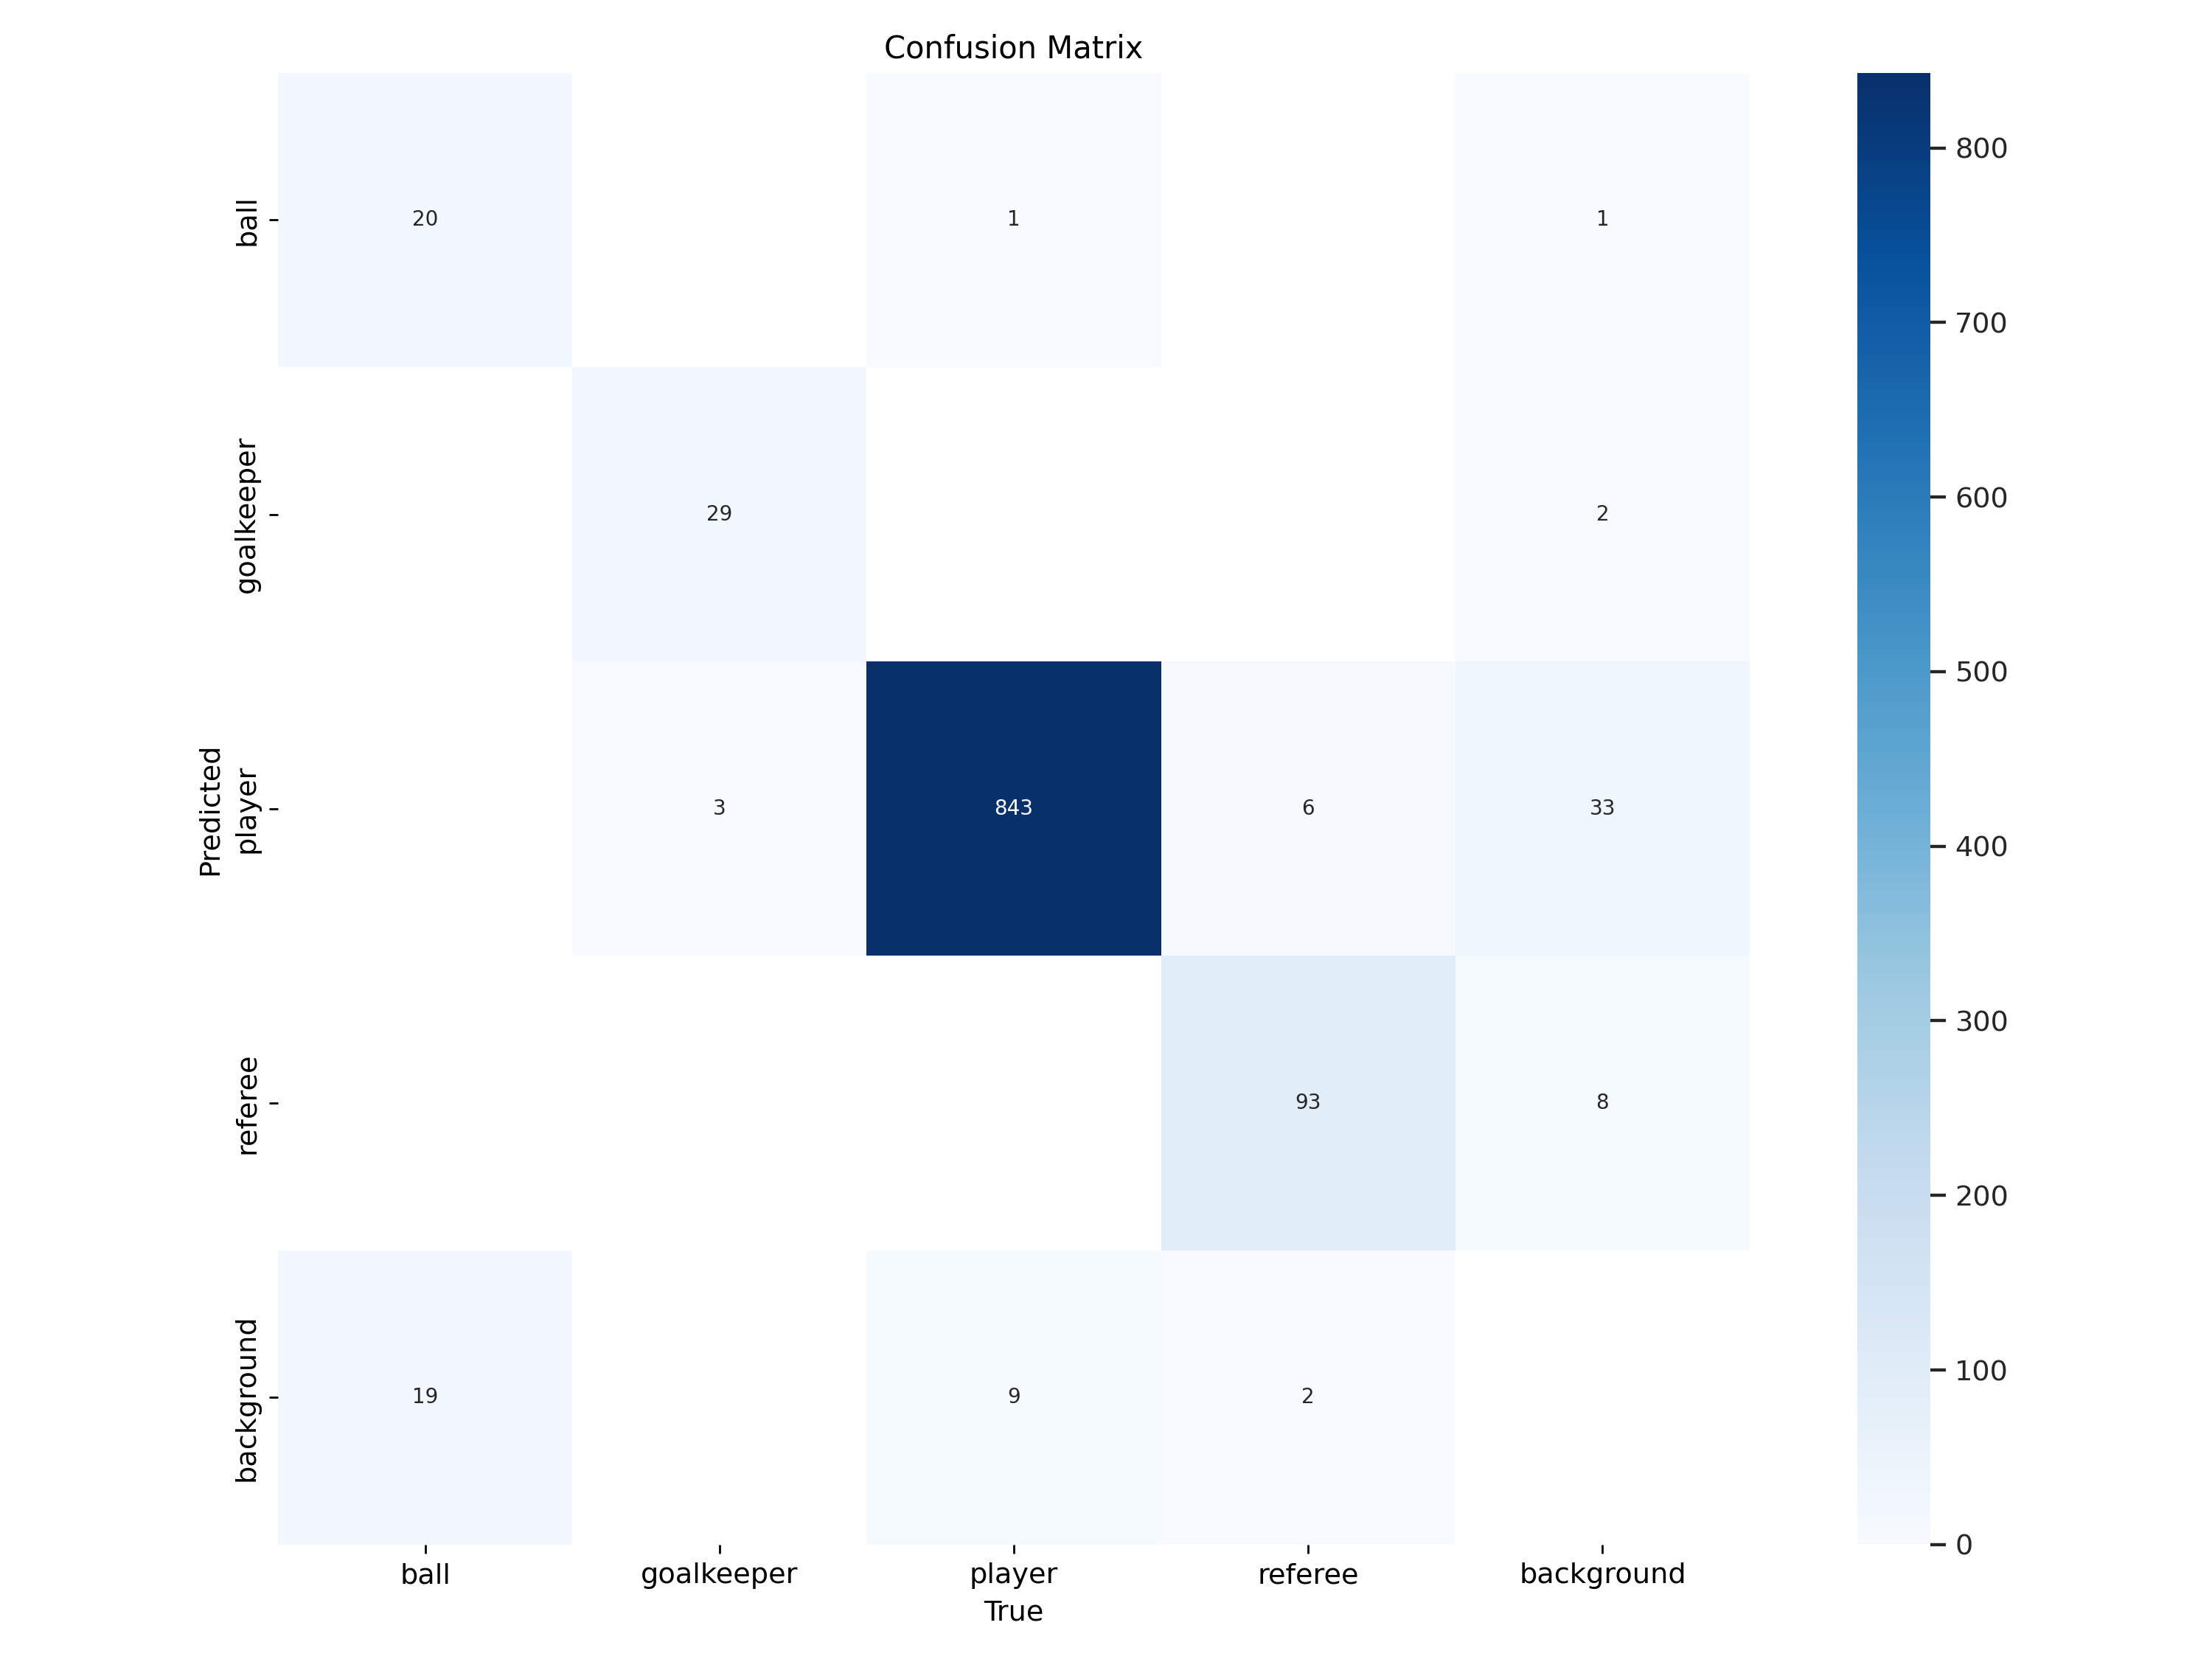

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

Модель хорошо распознает игроков — видно по числу 843 правильных предсказаний.
Иногда она путает вратаря с игроком (3 случая) и не всегда отличает мяч, игрока или судью от фона. Также заметна небольшая путаница игрока и судьи. Но в процентом отношении она не играет роли, как и предыдущие ошибки.

/content


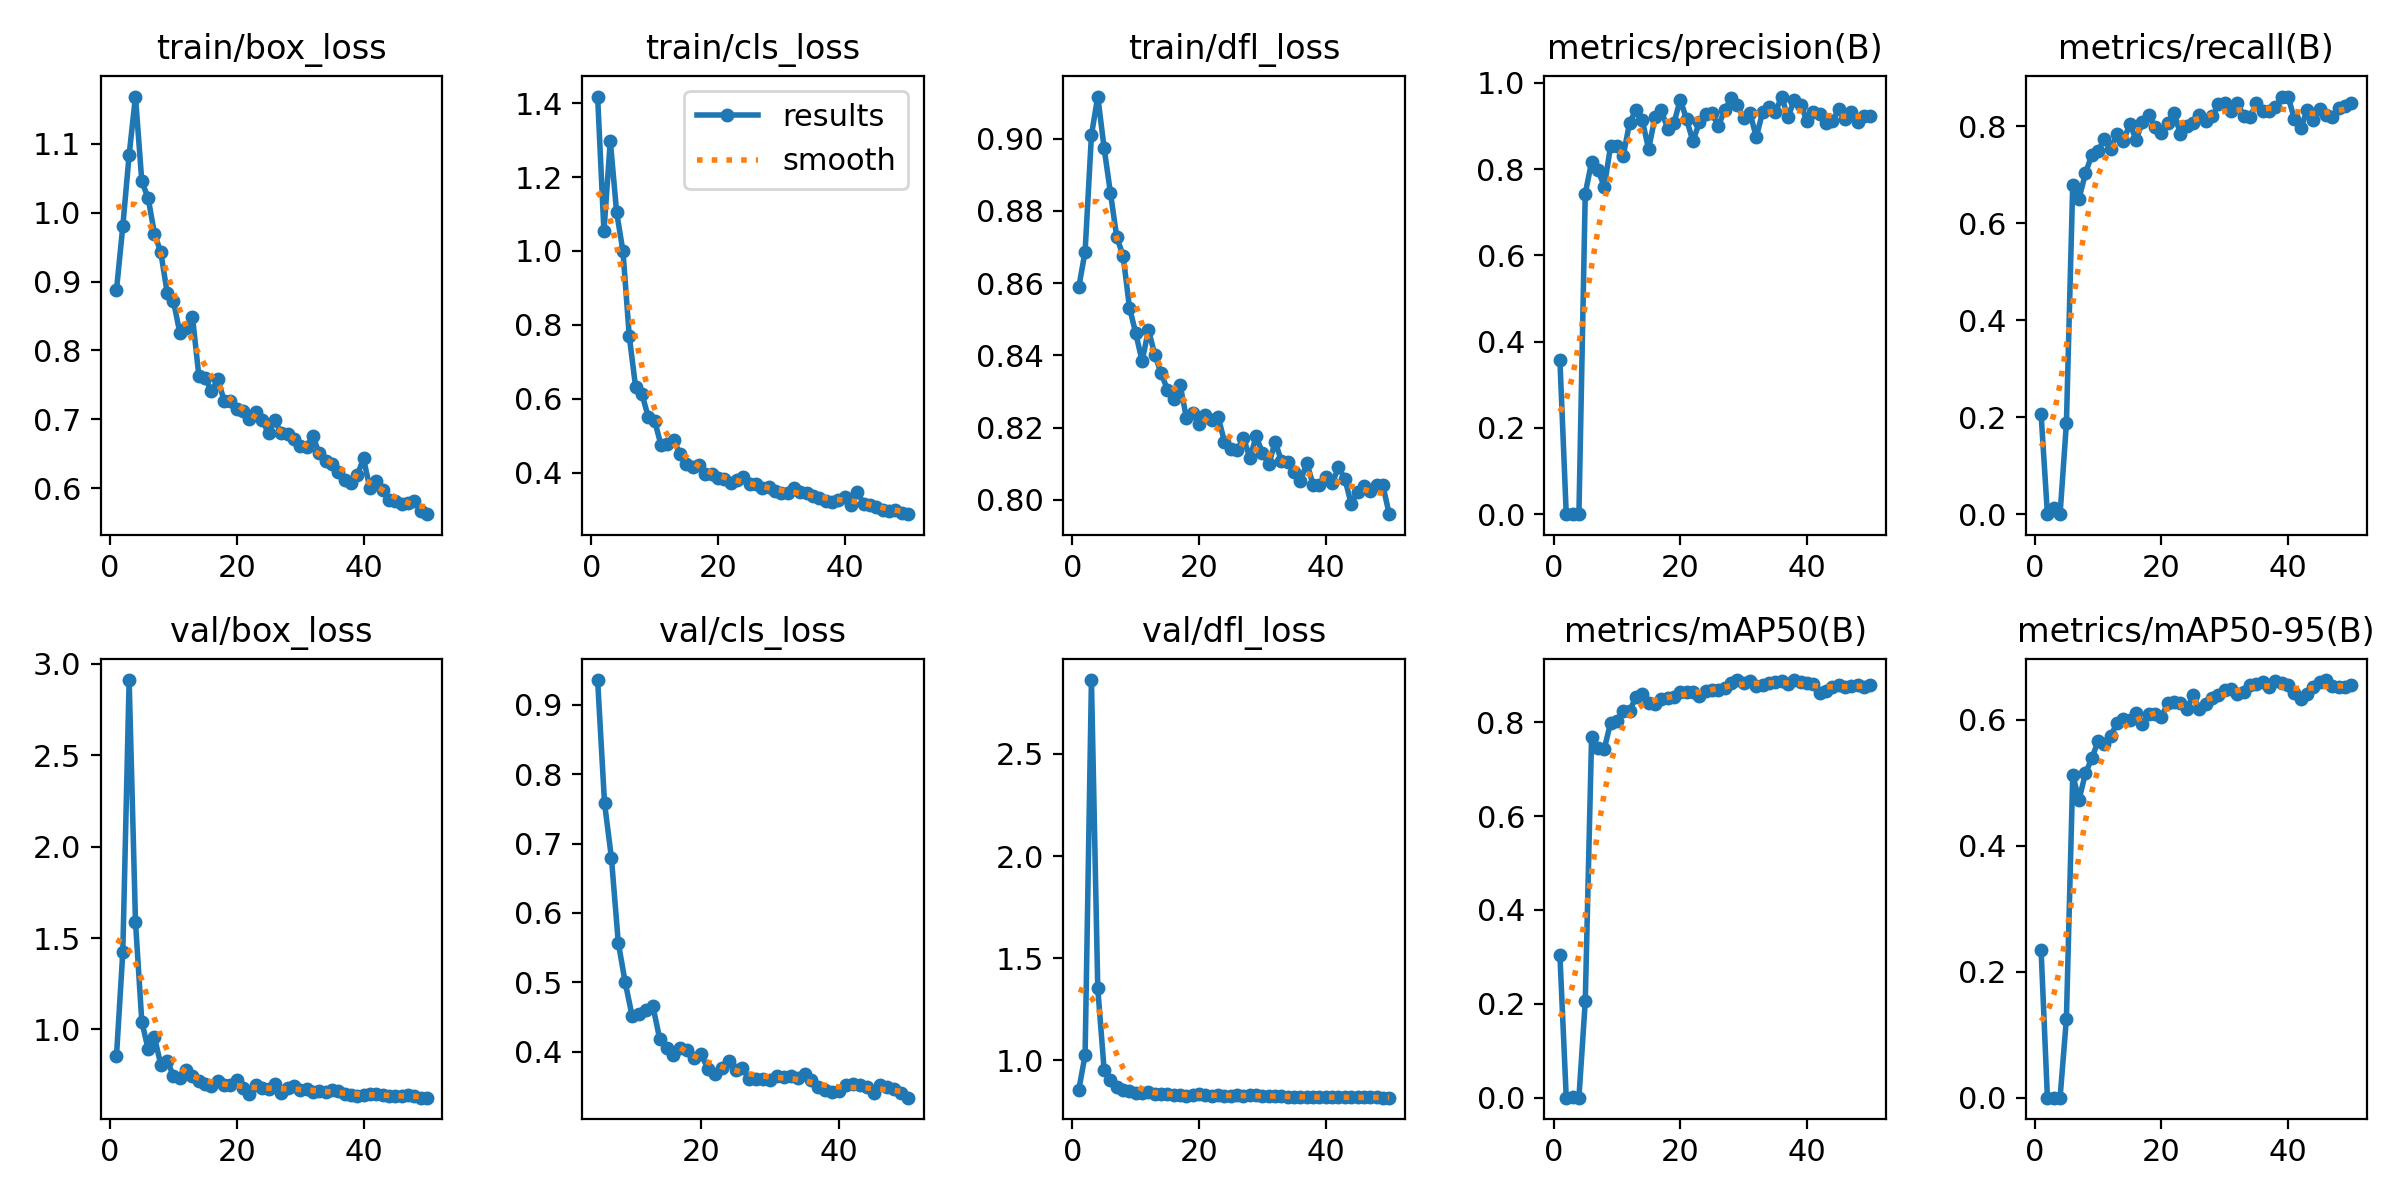

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## 5.2 Визуализация результата детекции игроков

/content


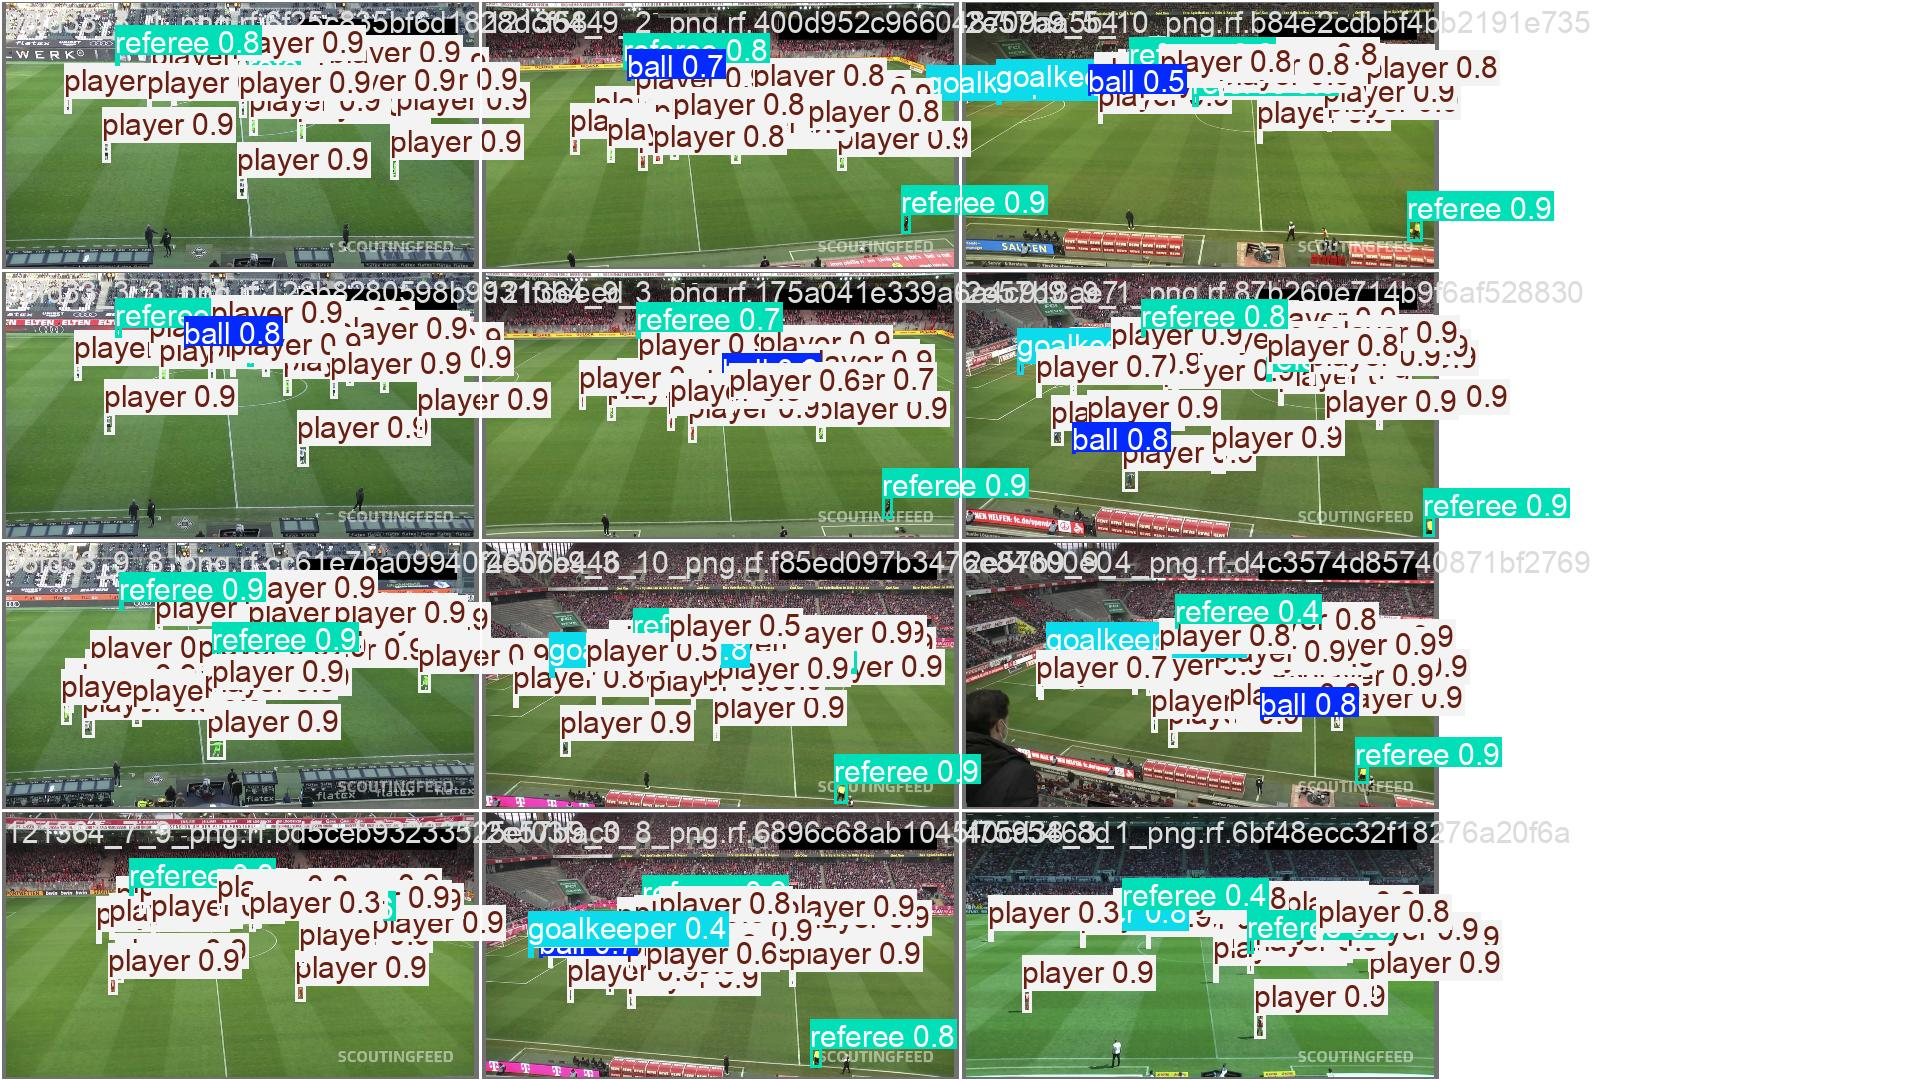

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/content
Ultralytics 8.3.131 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 68,127,420 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3309.6±686.7 MB/s, size: 223.0 KB)
val: Scanning /content/datasets/football-players-detection-10/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100% 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:04<00:00,  1.42s/it]
                   all         43       1025      0.963       0.84       0.89      0.673
                  ball         39         39      0.952      0.507      0.617      0.321
            goalkeeper         32         32      0.968      0.936      0.962      0.789
                player         43        853      0.967      0.986      0.994      0.861
               referee         43        101      0.967      0.931      0.986      0.719
Speed: 6.2ms preproc

### Модель хорошо научилась распознавать полевых игроков, вратарей и судей, в чем и заключалась суть обучения в этом проекте.

 ## Вывод: модель обучилась успешно, переобучения не видно, и можно переходить к деплою и дальнейшему инференсу.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/runs/detect/train/weights/best.pt \
    /content/drive/MyDrive/

Mounted at /content/drive
